<a href="https://colab.research.google.com/github/justina-tran/yelp-reviews/blob/master/yelp_reviews_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sentiment Analysis on Yelp Reviews - NLP

**Dataset: Yelp Reviews from NYC Boba Stores** \\
I used selenium to web scrap yelp to gather user reviews from 50 boba stores in NYC, curating a dataset with about 13K rows.

This notebook covers the data preprocessing steps and EDA.

### Data Preprocessing:
1. expand contractions, tokenize words, apply stopwords, lowercase
2. get rid of non-english words (to-do)
3. word embedding - convert cleaned text to numerical representations (word vectors)

### EDA:
- how many reviews per stores, how many star ratings, user location, data, etc.
- viz of word cloud
- ngrams for each rating
- sentiment analysis on polarity and subjectivity using Vader
- frequency of tokens - what words are most frequently in 5 star and 1 star reviews.

### Data Modeling: 
- Build a Classifier - apply grid search for different models and hyperparameter tuning
- Apply topic modeling - summarize reviews

In [ ]:
!pip install -q contractions 

     |████████████████████████████████| 287 kB 7.2 MB/s 
     |████████████████████████████████| 106 kB 82.5 MB/s 


In [ ]:
!pip install -q gensim

In [ ]:
import pandas as pd
import seaborn as sns

# setting dir
import os
os.chdir('/content/drive/MyDrive/Projects/NLP/data')

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import re, string
import nltk
import contractions
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
review_df = pd.read_csv('nyc_reviews_final.csv')
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13211 entries, 0 to 13210
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   store     13211 non-null  object
 1   date      13211 non-null  object
 2   username  13211 non-null  object
 3   user_loc  13211 non-null  object
 4   rating    13211 non-null  object
 5   reviews   13211 non-null  object
dtypes: object(6)
memory usage: 619.4+ KB


In [ ]:
store_reviews = review_df['store'].value_counts().reset_index()
store_reviews.columns = ['store','num of reviews']
fig = px.bar(store_reviews, x='store', y='num of reviews', title="Review Count for Each Store")
fig.show()

In [ ]:
ratings = review_df['rating'].value_counts().reset_index()
ratings.columns = ['rating','num of reviews']
fig = px.pie(ratings, values='num of reviews', names='rating', title='Rating Distribution')
fig.show()

Just over half of the dataset is made up of reviews with 5 star rating. So we are dealing with a highly imbalanced dataset.

In [ ]:
# where are users who leave reviews coming from?
store_reviews = review_df['user_loc'].value_counts().reset_index().head(10)
store_reviews.columns = ['location','num of reviews']
fig = px.bar(store_reviews, x='location', y='num of reviews')
fig.show()

Most of the reviewers are from NYC as expected, and some are from California and Boston.

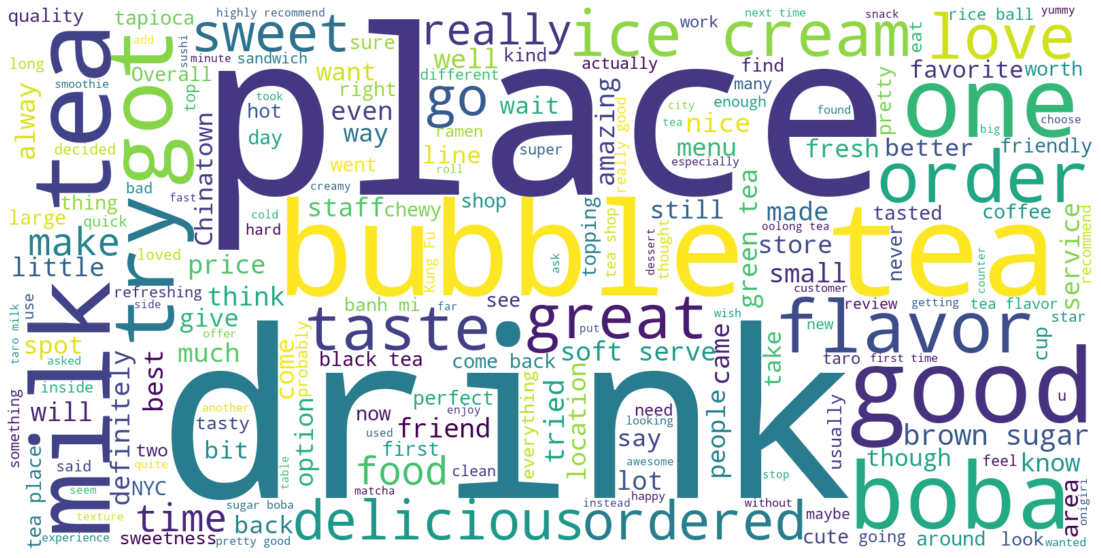

In [ ]:
text = " ".join(review for review in review_df.reviews)

my_stopwords = set(STOPWORDS)
#my_stopwords.update(["boba", "bubble", "place", "tea"])

wordcloud = WordCloud(width=1600, height=800, background_color='white', stopwords=my_stopwords).generate(text)

# Display the generated image:
plt.figure( figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Cleaning Data

In [ ]:
def remove_noise(tweet_tokens, stop_words = ()):
  """
  This function removes noise such as hyperlinks, special symbols, and punctuation.
  It also applies lemmatization given the tag of each token.
  
  """
  cleaned_tokens = []
  for token, tag in pos_tag(tweet_tokens):
      # convert text to lowercase
      token = token.lower()
      # remove hyperlinks
      token = re.sub('https?:\/\/[^\s\n\r]+','',token)
      # remove numbers like '10 10'
      token = re.sub('[0-9]\b*','',token)
      # apply lemmatization
      if tag.startswith("NN"):
          pos = 'n'
      elif tag.startswith('VB'):
          pos = 'v'
      else:
          pos = 'a'
      lemmatizer = WordNetLemmatizer()
      token = lemmatizer.lemmatize(token, pos)

      if len(token) > 2 and token not in string.punctuation and token.lower() not in stop_words and not token.isdigit():
          cleaned_tokens.append(token.lower())
  return cleaned_tokens


def cleaner(text):
  # expand contractions
  text = contractions.fix(text)
  # tokenize text
  tokenize_words = word_tokenize(text)  
  # return clean tokens
  return remove_noise(tokenize_words, stop_words)

In [ ]:
# add the stopwords to Stopword list for modeling
stop_words = stopwords.words('english')
custom = ['boba', 'bubble', 'tea']
for i in custom:
  stop_words.append(i)

In [ ]:
# token words for preprocessing
review_df['cleaned'] = review_df['reviews'].apply(cleaner)

In [ ]:
def token_to_str(token_list):
  return ' '.join(str(t) for t in token_list)
review_df['cleaned_text'] = review_df['cleaned'].apply(token_to_str)
review_df.head()

,store,date,username,user_loc,rating,reviews,cleaned,cleaned_text
0,bar-pa-tea-new-york-2,11/29/2020,Casey W.,"New York, NY",5 star rating,- absolutely one of my favorite ice cream plac...,"[absolutely, one, favorite, ice, cream, place,...",absolutely one favorite ice cream place city r...
1,bar-pa-tea-new-york-2,8/13/2020,Marie R.,"Edgewater, NJ",1 star rating,My experience was really bad. I'm usually a bu...,"[experience, really, bad, usually, fanatic, th...",experience really bad usually fanatic think pl...
2,bar-pa-tea-new-york-2,7/21/2020,Mariama K.,"Los Angeles, CA",3 star rating,Good but not amazing. Staff was not very frien...,"[good, amazing, staff, friendly, minimal, seat...",good amazing staff friendly minimal seating ge...
3,bar-pa-tea-new-york-2,6/25/2020,Veon C.,"Washington, DC",5 star rating,One of the best boba I've ever had. I usually ...,"[one, best, ever, usually, get, adffogato, bel...",one best ever usually get adffogato believe va...
4,bar-pa-tea-new-york-2,6/14/2020,Jessleen C.,"Flushing, NY",5 star rating,I saw this place everyone on my timeline and h...,"[saw, place, everyone, timeline, check, disapp...",saw place everyone timeline check disappoint g...


In [ ]:
corpus_wordcloud = " ".join(str(review) for review in review_df.cleaned_text)
vocabulary = [word for review in review_df.cleaned for word in review]
print(corpus_wordcloud[:100])
print(vocabulary[:15])

absolutely one favorite ice cream place city recommend swirl black tea/oolong large mini black defin
['absolutely', 'one', 'favorite', 'ice', 'cream', 'place', 'city', 'recommend', 'swirl', 'black', 'tea/oolong', 'large', 'mini', 'black', 'definitely']


In [ ]:
corpus = [review for review in review_df.cleaned_text] #comma separated in list
print(corpus[:2])

['absolutely one favorite ice cream place city recommend swirl black tea/oolong large mini black definitely strong flavor almost coffee aftertaste almost always wait fresh tapioca batch throughout day hear place survive pandemic really hope come back dust settle', 'experience really bad usually fanatic think place cute look delicious order large oolong ice little sweet ice cream top saw picture think add matcha ice cream would good look good hand ombré color put straw gross bitter handle bitter like poor quality bitter ice cream portion figure would taste good creamy icy weird like brewer ice cream melt freeze creamy experience hearing ice cream expert quality ice cream depend milk cream egg start melt fast take creamy texture rich flavor good quality bad quality really hard icy cream milk poor quality blend well know ice cream no-go husband get large iced matcha green say gross drink mine way nasty girl counter want fix issue end throw drink trash husband fight drinking least half thr

In [ ]:
print(review_df['reviews'][0])
print(corpus[0])

- absolutely one of my favorite ice cream places in the city
- recommend: swirl (black tea/oolong tea) w/ large and mini bubbles
- black tea is definitely stronger in flavor and almost has a coffee aftertaste
- almost always a wait
- fresh tapioca batches throughout the day
- I heard this place didn't survive the pandemic but I really hope they come back once the dust settles
absolutely one favorite ice cream place city recommend swirl black tea/oolong large mini black definitely strong flavor almost coffee aftertaste almost always wait fresh tapioca batch throughout day hear place survive pandemic really hope come back dust settle


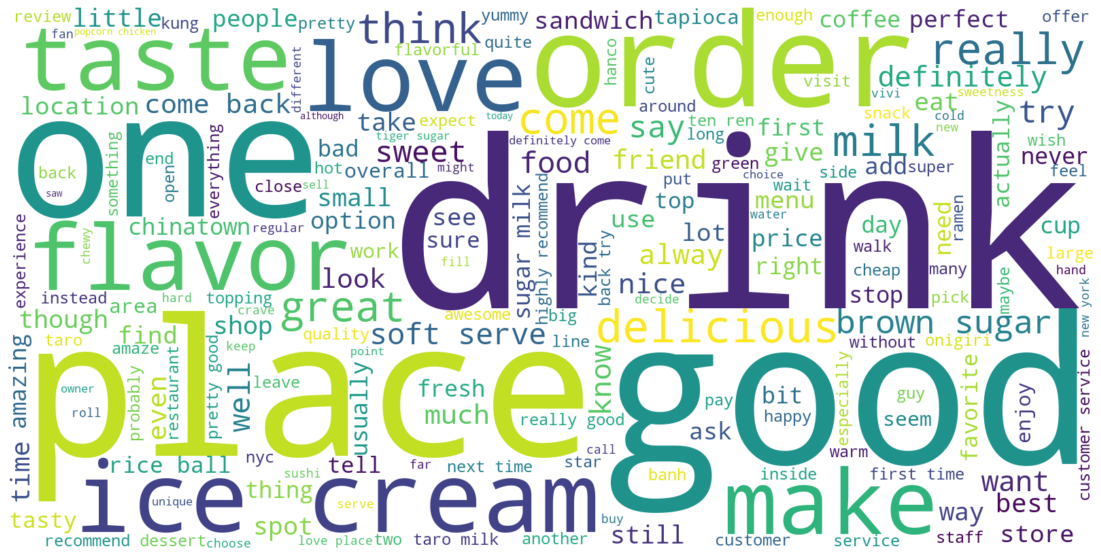

In [ ]:
my_stopwords.update("drink")

# word cloud with cleaned data
wordcloud = WordCloud(width=1600, height=800, background_color='white', stopwords=my_stopwords).generate(corpus_wordcloud)
# Display the generated image:
plt.figure( figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Analyze Top Words

In [ ]:
five_rating_vocab = [word for review in review_df[review_df['rating'] == '5 star rating']['cleaned'] for word in review]
one_rating_vocab = [word for review in review_df[review_df['rating'] == '1 star rating']['cleaned'] for word in review]

five_rating_corpus = [review for review in review_df[review_df['rating'] == '5 star rating']['cleaned_text']]
one_rating_corpus = [review for review in review_df[review_df['rating'] == '1 star rating']['cleaned_text']]

In [ ]:
five_rating_corpus[:3]

['absolutely one favorite ice cream place city recommend swirl black tea/oolong large mini black definitely strong flavor almost coffee aftertaste almost always wait fresh tapioca batch throughout day hear place survive pandemic really hope come back dust settle',
 'one best ever usually get adffogato believe vanilla ice cream inside love choice size small regular small one easy chew prefer also soft swerve add best world place nice aesthetic would come everyday far love drink highly recommend also near soho shop sip favorite',
 'saw place everyone timeline check disappoint get oolong ice cream chewy oolong ice cream leave bit bitter aftertaste expect oolong ice cream highly recommend place']

In [ ]:
# get freq of words
freq_dist = FreqDist(five_rating_vocab)
five_freq_dist_df = pd.DataFrame(freq_dist.most_common(100), columns=['Word', 'Count'])
five_freq_dist_df.head(20)

,Word,Count
0,place,4248
1,get,3853
2,drink,3272
3,good,3168
4,milk,3029
5,try,2663
6,love,2221
7,like,2213
8,great,2166
9,order,2133


In [ ]:
# get freq of words
freq_dist = FreqDist(one_rating_vocab)
one_freq_dist_df = pd.DataFrame(freq_dist.most_common(100), columns=['Word', 'Count'])
one_freq_dist_df.head(20)

,Word,Count
0,order,460
1,drink,370
2,get,319
3,place,296
4,like,280
5,milk,276
6,taste,228
7,good,221
8,make,203
9,time,202


In [ ]:
# get words that are frequently in 5 star reviews and not in 1 star reviews using left join
freqs = five_freq_dist_df.merge(one_freq_dist_df, on='Word', how='left', suffixes=('_5','_1'), indicator=True)


fig = px.bar(freqs[freqs['_merge']=='left_only'].head(20), x='Word', y='Count_5', title="Most Frequent Words in 5 Star Reviews")
fig.show()

In [ ]:
# get words freq in 1 star reviews that's not in 5 star reviews
freqs = five_freq_dist_df.merge(one_freq_dist_df, on='Word', how='right', suffixes=('_5','_1'), indicator=True)

top_ones = freqs[freqs['_merge']=='right_only'].head(20)
fig = px.bar(top_ones, x='Word', y='Count_1', title="Most Frequent Words in 1 Star Reviews")
fig.show()

# Text Vectorization
`TfidfVectorizer` and `CountVectorizer` are both methods for converting text data into vectors or numerical representation as models can process only numerical data. This process is also known as word embeddings.

---

**CountVectorizer vs. TfidfVectorizer** \
With `CountVectorizer`, it only counts the number of times a word appears in the document which results in biasing in favor of most frequent words. This approach does not consider rare or more relevant words which could help us get more valuable meaning from words. `TfidfVectorizer` is better than `CountVectorizer` because it considers the frequency and importance of words. 
In short, "TF" counts a term in a sentence (or review in this case), and "DF" is the number of documents (or reviews) with the term. 



In [ ]:
# def create_ngram(text, n, vectorizer = 'tfidf'):
#     if vectorizer == 'tfidf':
#       # need to perform train/test split
#       tfidf = TfidfVectorizer(
#         lowercase=True,
#         # max_features=100,
#         # max_df=0.2,
#         # min_df=1,
#         ngram_range=(n,n), 
#         stop_words=stop_words
#       )
#       X = tfidf.fit_transform(text)
#       print(X.shape)
#       bigram_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())
#       bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
#       bigram_frequency.columns = ['n-gram', 'frequency']
#       bigram_frequency = bigram_frequency.sort_values(by='frequency', ascending=False).head(10)
#       bigram_frequency
#       # plot bigram freq
#       fig = px.bar(bigram_frequency, x="n-gram", y="frequency",  title="N-gram Frequency Using TF-IDF")
#       #st.plotly_chart(fig, use_container_width=True)
#       fig.show()

#     else:
#       vect = CountVectorizer(stop_words=stop_words, ngram_range=(n,n))
#       bigrams = vect.fit_transform(text)
#       bigram_df = pd.DataFrame(bigrams.toarray(), columns=vect.get_feature_names_out())
#       bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
#       bigram_frequency.columns = ['n-gram', 'frequency']
#       bigram_frequency = bigram_frequency.sort_values(by='frequency', ascending=False).head(10)
#       # plot bigram freq
#       fig = px.bar(bigram_frequency, x="n-gram", y="frequency",  title="N-gram Frequency Using CountVectorizer")
#       #st.plotly_chart(fig, use_container_width=True)
#       fig.show()

In [ ]:
def create_ngram(text, n):
  # ngrams counts
  count_vect = CountVectorizer(ngram_range = (n,n),
                               max_features=500,
                               stop_words=stop_words)
  cv_matrix = count_vect.fit_transform(text) 
  features = (count_vect.get_feature_names_out())

  cv_df = pd.DataFrame(cv_matrix.toarray(), columns=features)
  display(cv_df.head(10))

  # ngrams tfidf
  tfidf = TfidfVectorizer(ngram_range = (n,n),
                          max_features=500,
                          # max_df=0.2,
                          # min_df=1, 
                          stop_words=stop_words)
  tfidf_matrix = tfidf.fit_transform(text)
  scores = (tfidf_matrix.toarray())
  tfidf_df = pd.DataFrame(scores, columns=tfidf.get_feature_names_out())
  display(tfidf_df.head(10))

  # Getting top relevant ngrams based on tfidf
  tfidf_score = tfidf_matrix.sum(axis=0) # sum of the tfidf score
  counts = cv_matrix.sum(axis=0) # frequency count
  data = []
  for i, term in enumerate(features):
    data.append( (term, tfidf_score[0,i], counts[0,i]))
  ranking = pd.DataFrame(data, columns = ['term','tfidf', 'counts'])
  
  # plot ngram freq ordered by tfidf score
  words = ranking.sort_values('tfidf', ascending = False).head(10)
  fig = px.bar(words, x="term", y="counts", hover_data=["tfidf"], title="N-gram Frequency Using TF-IDF")
  #st.plotly_chart(fig, use_container_width=True)
  fig.show()

In [ ]:
def get_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_score = sid.polarity_scores(text)

    pos = round((sentiment_score['pos']), 2)*100
    neg = round((sentiment_score['neg']), 2)*100
    neutral = round((sentiment_score['neu']), 2)*100
    compound = round((sentiment_score['compound']), 2)*100

    vader_df = pd.DataFrame({"text":[text], "positive":[pos], "negative":[neg], "neutral":[neutral]})
    vader_df = vader_df[['positive', 'negative', 'neutral']].T.reset_index()
    vader_df.columns = ['sentiment', '%']

    fig = px.pie(vader_df, values='%', names='sentiment',title="Sentiment")
    fig.update_traces(texttemplate="%{percent:.0%}")
    #st.plotly_chart(fig, use_container_width=True)
    fig.show()

In [ ]:
create_ngram(five_rating_corpus, 2)

,absolutely delicious,absolutely love,acai bowl,across street,actually taste,addition neighborhood,adjust sugar,almond milk,also get,also good,...,worth wait,would come,would definitely,would get,would highly,would like,would recommend,would say,write review,year ago
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


,absolutely delicious,absolutely love,acai bowl,across street,actually taste,addition neighborhood,adjust sugar,almond milk,also get,also good,...,worth wait,would come,would definitely,would get,would highly,would like,would recommend,would say,write review,year ago
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.363571,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.554572,0.0,0.000000,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.273254,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.237185,0.0,0.000000,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.207604,0.0,0.000000,0.0


In [ ]:
create_ngram(five_rating_corpus, 3)

,absolutely love place,accept credit card,actually taste like,adjust sugar level,also really good,always come back,always want try,ask less sugar,authentic taiwanese food,açaí bowl ever,...,would definitely get,would definitely recommend,would highly recommend,would like try,would love come,would recommend anyone,would recommend get,would recommend place,would recommend try,zhou beef noodle
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,absolutely love place,accept credit card,actually taste like,adjust sugar level,also really good,always come back,always want try,ask less sugar,authentic taiwanese food,açaí bowl ever,...,would definitely get,would definitely recommend,would highly recommend,would like try,would love come,would recommend anyone,would recommend get,would recommend place,would recommend try,zhou beef noodle
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
create_ngram(one_rating_corpus,2)

,across street,add milk,add water,ajisen ramen,almond milk,also make,also put,another chance,another minute,another try,...,would never,would order,would recommend,would say,would think,write review,wrong drink,wrong order,year old,zero star
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,across street,add milk,add water,ajisen ramen,almond milk,also make,also put,another chance,another minute,another try,...,would never,would order,would recommend,would say,would think,write review,wrong drink,wrong order,year old,zero star
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.364002,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
create_ngram(one_rating_corpus, 3)

,absolutely taste think,act like want,add one spicy,add soft serve,adjust ice level,almond milk leave,alright nothing special,also sell rolled,also taste like,angel hair pasta,...,would never order,would prefer refund,would recommend anyone,would recommend place,would say place,would taste good,wow officially say,yelp takeout order,yuck stay away,zero star could
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,absolutely taste think,act like want,add one spicy,add soft serve,adjust ice level,almond milk leave,alright nothing special,also sell rolled,also taste like,angel hair pasta,...,would never order,would prefer refund,would recommend anyone,would recommend place,would say place,would taste good,wow officially say,yelp takeout order,yuck stay away,zero star could
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.33503,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.540468,0.00000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0


## Sentiment Analysis
Apply vader sentiment analysis
- VADAR (Valence Aware Dictionary for Sentiment Reasoning): get pos/neg/neutral sentiment probability scores that add up to 100. There is also a compound score which is the normalized score that calculates the sum of all lexicon ratings and takes values from -1 to 1.


In [ ]:
sid = SentimentIntensityAnalyzer()

def get_sentiment(row, **kwargs):
    sentiment_score = sid.polarity_scores(row)
    if kwargs['k'] == 'positive':
      score_meter = round((sentiment_score['pos']), 2)
    elif kwargs['k'] == 'negative':
      score_meter = round((sentiment_score['neg']), 2) 
    elif kwargs['k'] == 'neutral':
      score_meter = round((sentiment_score['neu']), 2)
    elif kwargs['k'] == 'compound':
      score_meter = round((sentiment_score['compound']), 2)
    else:
      print('none')
    return score_meter

#add labels to df
review_df['positive'] = review_df['reviews'].apply(get_sentiment, k='positive')
review_df['negative'] = review_df['reviews'].apply(get_sentiment, k='negative')
review_df['neutral'] = review_df['reviews'].apply(get_sentiment, k='neutral')
review_df['compound'] = review_df['reviews'].apply(get_sentiment, k='compound')

# positive: compound score>=0.05
# neutral: compound score between -0.05 and 0.05
# negative: compound score<=-0.05
review_df['sentiment']=''
review_df.loc[review_df.compound >= 0.05, 'sentiment'] = 'positive'
review_df.loc[review_df.compound.between(-0.05, 0.05), 'sentiment'] = 'neutral'
review_df.loc[review_df.compound <= -0.05, 'sentiment'] = 'negative'

In [ ]:
review_df['sentiment'].value_counts()

positive    12081
negative      979
neutral       151
Name: sentiment, dtype: int64

In [ ]:
review_df.groupby(['rating'])['sentiment'].value_counts()

rating         sentiment
1 star rating  negative      324
               positive      197
               neutral        12
2 star rating  positive      402
               negative      214
               neutral        23
3 star rating  positive     1205
               negative      194
               neutral        32
4 star rating  positive     3612
               negative      137
               neutral        48
5 star rating  positive     6665
               negative      110
               neutral        36
Name: sentiment, dtype: int64

Text(0.5, 0.98, 'Sentiment scores using Vader')

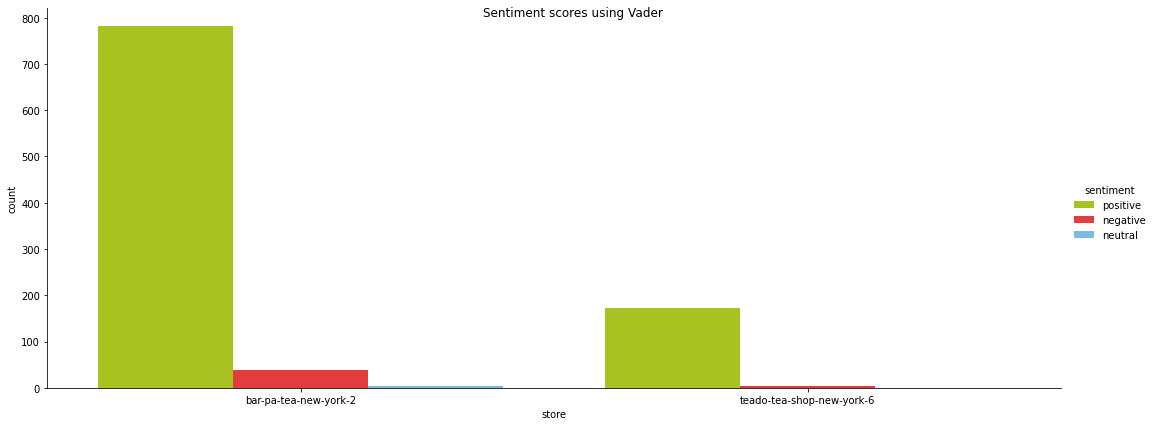

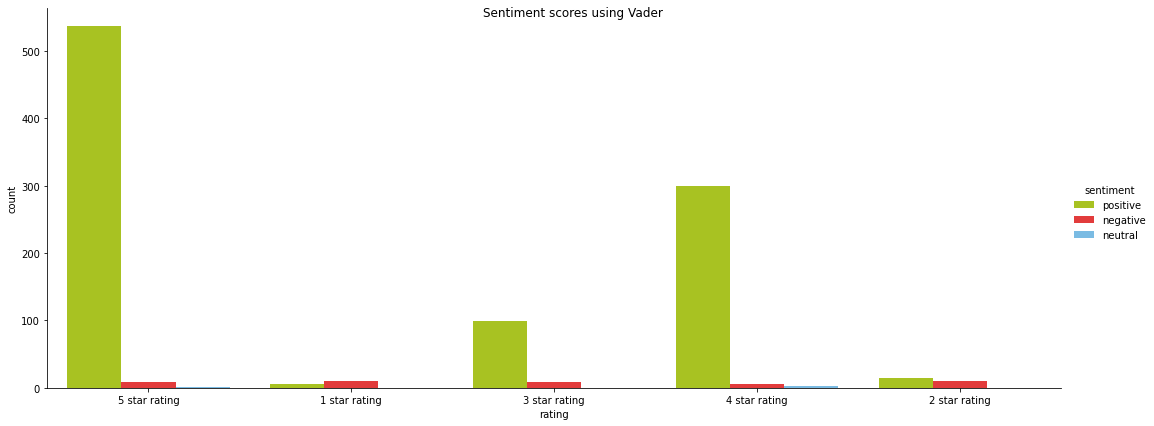

In [ ]:
# plot sentiment scores from using vader
vader_src = sns.catplot(x="store", hue="sentiment", 
                    data=review_df.head(1000), kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"}, height=6, aspect=2.5)
vader_src.fig.suptitle('Sentiment scores using Vader')

# plot sentiment scores from using vader
vader_src = sns.catplot(x="rating", hue="sentiment", 
                    data=review_df.head(1000), kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"}, height=6, aspect=2.5)
vader_src.fig.suptitle('Sentiment scores using Vader')

In [ ]:
one_star = review_df[review_df['rating']=='1 star rating']
print(one_star['sentiment'].iloc[0])
print(one_star['reviews'].iloc[0])

negative
My experience was really bad. I'm usually a bubble tea fanatic and I thought this place was cute and it looked delicious. I went and ordered a large oolong iced tea with bubbles with a little sweet and with ice cream on top.

I saw the pictures and thought by adding matcha ice cream to it would be good. It looked good when they handed it to me, it was ombré colored.
But when I put my straw in it was so gross. It was so bitter. I can handle bitter, but it was like a poor quality tea bitter.

As for the ice cream portion, I figured that it would taste good but it wasn't creamy at all it was icy and weird. Like Brewer's ice cream when it melts and then you freeze it again. Not creamy.

From experience and hearing from ice cream experts, the quality of the ice cream depends on the milk, cream and eggs. If it starts to melt fast after you take it out and it's creamy in texture and has a rich flavor then it's good quality. It's bad quality if it's really hard, icy (from the cream an

In [ ]:
five_star = review_df[review_df['rating']=='5 star rating']
print(five_star['sentiment'].iloc[0])
print(five_star['reviews'].iloc[0])

positive
- absolutely one of my favorite ice cream places in the city
- recommend: swirl (black tea/oolong tea) w/ large and mini bubbles
- black tea is definitely stronger in flavor and almost has a coffee aftertaste
- almost always a wait
- fresh tapioca batches throughout the day
- I heard this place didn't survive the pandemic but I really hope they come back once the dust settles


In [ ]:
four_star = review_df[review_df['rating']=='4 star rating']
print(four_star['sentiment'].iloc[7])
print(four_star['reviews'].iloc[7])
print(four_star['cleaned'].iloc[7])

positive
The bubble tea here is fresh and authentic! Make sure you don't order off of Ritual so that you can participate in their rewards program on the Clover app, where you get 10% off your purchases and get a free drink or soft serve after buying 8 of either one. The drinks are a little more on the pricey side unfortunately, but the quality is good & I love how they offer lots of dairy-free options.

This place is also super cute! A great place to go with friends or family.
['fresh', 'authentic', 'make', 'sure', 'order', 'ritual', 'participate', 'reward', 'program', 'clover', 'app', 'get', 'purchase', 'get', 'free', 'drink', 'soft', 'serve', 'buy', 'either', 'one', 'drink', 'little', 'pricey', 'side', 'unfortunately', 'quality', 'good', 'love', 'offer', 'lot', 'dairy-free', 'option', 'place', 'also', 'super', 'cute', 'great', 'place', 'friend', 'family']


In [ ]:
three_star = review_df[review_df['rating']=='3 star rating']
print(three_star['sentiment'].iloc[10])
print(three_star['reviews'].iloc[10])
print(three_star['cleaned'].iloc[10])

negative
This place always seems to mess up my order. I came here on two separate occasions, at least a year apart and both times my order was incorrect. The first time I came, I came by myself and I ordered one of the soft serves and asked for MINI bubbles bc I dont like the regular bubbles - just personal preference for any bubble tea shop. I ended up receiving regular bubbles. Second time I came, I came with my bf and I ordered a roasted oolong tea latte with MINI bubbles again and he ordered a jasmine green tea latte with mix bubbles. Guess what I ended up getting? I got the mix bubbles and he got the mini bubbles in his drink. Theres really no excuse as to why they keep messing up my order. Its just really frustrating. Their drinks and soft serve are good, but I probably wont return for this reason.
['place', 'always', 'seem', 'mess', 'order', 'come', 'two', 'separate', 'occasion', 'least', 'year', 'apart', 'time', 'order', 'incorrect', 'first', 'time', 'come', 'come', 'order', 'o

In [ ]:
two_star = review_df[review_df['rating']=='2 star rating']
print(two_star['sentiment'].iloc[50])
print(two_star['reviews'].iloc[50])
print(two_star['cleaned'].iloc[50])

positive
Ugh..... I really really wish our first order was more successful.

I am Taiwanese descend ( for reference).

The ru lou fan was pretty good. The fried chicken and eggplant dishes were CRAZY salty！

I really hope the employees or owners actually eat the food they serve!

All the best,Victoria
['ugh', '.....', 'really', 'really', 'wish', 'first', 'order', 'successful', 'taiwanese', 'descend', 'reference', 'lou', 'fan', 'pretty', 'good', 'fried', 'chicken', 'eggplant', 'dish', 'crazy', 'salty！', 'really', 'hope', 'employee', 'owner', 'actually', 'eat', 'food', 'serve', 'best', 'victoria']


In [ ]:
def build_freqs(tokens_list, ys):
    """Build frequencies.
    Input:
        tokens: a list of tokens
        ys: an m x 1 array with the sentiment label of each article
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    yslist = np.squeeze(ys).tolist()

    # looping over all token list in each article 
    # and over all processed words in each token list.
    freqs = {}
    for y, token in zip(yslist, tokens_list):
      #iterate over words 
      splits = token.split()
      for word in splits:
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs

In [ ]:
# top words for each sentiment
pos_words = review_df[review_df['sentiment'] == 'positive']['cleaned_text']
neg_words = review_df[review_df['sentiment'] == 'negative']['cleaned_text']
all_words = pd.concat([pos_words, neg_words])
print(all_words.values.shape)

#create array of pos and neg labels
labels = np.append(np.ones((len(pos_words), 1)), np.zeros((len(neg_words), 1)), axis=0)
print(labels.shape)

(13060,)
(13060, 1)


In [ ]:
# create freq dict of the word and labels
freqs = build_freqs(all_words, labels)

# create dictionaries of neg and pos words freq
neg_words_freq = {}
pos_words_freq = {}
for key in freqs.keys():
  word, label = key
  if label == 0:
    neg_words_freq[word] = freqs[key]
  else:
    pos_words_freq[word] = freqs[key]

# create df of neg and pos frequencies 
neg_df = pd.DataFrame(neg_words_freq.items(), columns=['word', 'neg_count'])
pos_df = pd.DataFrame(pos_words_freq.items(), columns=['word', 'pos_count'])
pos_neg_df = pd.merge(neg_df, pos_df, on='word', how='outer')

# make neg count as neg values
pos_neg_df['neg_count'] = pos_neg_df['neg_count'] * -1
pos_neg_df.sort_values(by='pos_count', ascending=False).head(50)

,word,neg_count,pos_count
6,place,-497.0,7932.0
61,get,-600.0,7740.0
23,good,-395.0,7120.0
65,drink,-584.0,7100.0
47,milk,-464.0,6220.0
32,like,-404.0,5179.0
242,try,-238.0,4901.0
10,order,-604.0,4648.0
120,one,-267.0,3892.0
111,come,-267.0,3881.0


In [ ]:
# diverging plot of top pos/neg words
# plot the top counts
top_pos_neg_df = pos_neg_df.sort_values(by=['pos_count', 'neg_count'], ascending=False).head(20)
diverging = go.Figure()
colors = {'neg_count': 'red',
          'pos_count': 'green'}
s = pd.Series(colors)

# iterating over the pos/neg columns
for col in top_pos_neg_df.columns[1:]:
  diverging.add_trace(go.Bar(
        x=top_pos_neg_df['word'],
        y=top_pos_neg_df[col],
        #orientation='h',
        name=col,
        marker_color=colors[col],
        hovertemplate="%{x}: %{y}")
  )

  
# layout of the plot
diverging.update_layout(barmode='relative',
                        height=450,
                        width=1000,
                        bargap=0.5)

In [ ]:
def build_freq_bigrams(bigram_list, labels, corpus):
    """Build frequencies.
    Input:
        bigram_list: a list of bigrams
        labels: an m x 1 array with the sentiment label of each article
            (either 0 or 1)
        corpus: a list of all articles
    Output:
        freqs: a dictionary mapping each (bigram, sentiment) pair to its
        frequency in the entire corpus
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    yslist = np.squeeze(labels).tolist()
    bi_grams_freqs = {}
    for label, text in zip(yslist, corpus):
      for bigram in bigram_list:
        pair = (bigram, label)  
        if pair in bi_grams_freqs:
          bi_grams_freqs[pair] += text.count(bigram)
        else:
            bi_grams_freqs[pair] = 0
    
    return bi_grams_freqs

In [ ]:
#corpus = [words for words in all_words]
vect = CountVectorizer(stop_words=stop_words, ngram_range=(2,2), min_df=25) #change min_df with a larger dataset
bigrams = vect.fit_transform(corpus)
print(bigrams.shape)
bigram_list = vect.get_feature_names_out()
print(bigram_list)

(13060, 1692)
['able get' 'absolute favorite' 'absolutely delicious' ... 'yelp review'
 'yet try' 'york city']


In [ ]:
bigram_freq = build_freq_bigrams(bigram_list, labels, corpus)
bigram_freq

{('able get', 1.0): 57,
 ('absolute favorite', 1.0): 30,
 ('absolutely delicious', 1.0): 66,
 ('absolutely love', 1.0): 91,
 ('acai bowl', 1.0): 131,
 ('across street', 1.0): 76,
 ('actually taste', 1.0): 84,
 ('addition neighborhood', 1.0): 36,
 ('adjust sugar', 1.0): 64,
 ('adjust sweetness', 1.0): 33,
 ('ajisen ramen', 1.0): 90,
 ('almond milk', 1.0): 116,
 ('almost every', 1.0): 41,
 ('almost like', 1.0): 22,
 ('also add', 1.0): 30,
 ('also delicious', 1.0): 42,
 ('also get', 1.0): 161,
 ('also give', 1.0): 30,
 ('also good', 1.0): 104,
 ('also great', 1.0): 70,
 ('also like', 1.0): 70,
 ('also love', 1.0): 91,
 ('also make', 1.0): 50,
 ('also nice', 1.0): 35,
 ('also offer', 1.0): 60,
 ('also order', 1.0): 100,
 ('also pretty', 1.0): 45,
 ('also really', 1.0): 91,
 ('also sell', 1.0): 56,
 ('also serve', 1.0): 38,
 ('also super', 1.0): 45,
 ('also taste', 1.0): 28,
 ('also try', 1.0): 142,
 ('always come', 1.0): 44,
 ('always fresh', 1.0): 52,
 ('always friendly', 1.0): 53,
 ('alw

In [ ]:
# create dictionaries of neg and pos words freq
neg_bigram_freq = {}
pos_bigram_freq = {}
for key in bigram_freq.keys():
  bigram, label = key
  if label == 0:
    neg_bigram_freq[bigram] = bigram_freq[key]
  else:
    pos_bigram_freq[bigram] = bigram_freq[key]

neg_bigram_df = pd.DataFrame(neg_bigram_freq.items(), columns=['bigram', 'neg_count'])
pos_bigram_df = pd.DataFrame(pos_bigram_freq.items(), columns=['bigram', 'pos_count'])
bigram_pos_neg_df = pd.merge(neg_bigram_df, pos_bigram_df, on='bigram', how='outer')

# make neg count as neg values
bigram_pos_neg_df['neg_count'] = bigram_pos_neg_df['neg_count'] * -1
bigram_pos_neg_df.sort_values(by='pos_count', ascending=False).head(50)

,bigram,neg_count,pos_count
652,ice cream,-108,2303
120,brown sugar,-77,1543
1322,soft serve,-42,1297
162,come back,-49,1048
1482,taste like,-69,583
1387,sugar milk,-32,582
1227,rice ball,-27,565
1195,really good,-8,545
637,highly recommend,-4,531
1144,pretty good,-9,507


In [ ]:
# add pos/neg ratios to df
bigram_df = bigram_pos_neg_df.copy()
bigram_df['pos_perc'] = bigram_df['pos_count'] / abs(bigram_df['neg_count'])
bigram_df['neg_perc'] = abs(bigram_df['neg_count']) / bigram_df['pos_count']
bigram_df

# diverging plot of top pos/neg bigrams
# plot the top counts
bigram_df_pos = bigram_df.sort_values(by=['pos_perc'], ascending=False).head(20)
diverging = go.Figure()
colors = {'neg_count': 'red',
          'pos_count': 'green'}
s = pd.Series(colors)

# iterating over the pos/neg columns
for col in bigram_df_pos.columns[1:3]:
  diverging.add_trace(go.Bar(
        x=bigram_df_pos['bigram'],
        y=bigram_df_pos[col],
        #orientation='h',
        name=col,
        marker_color=colors[col],
        hovertemplate="%{x}: %{y}")
  )

  
# layout of the plot
diverging.update_layout(barmode='relative',
                        height=450,
                        width=1000,
                        bargap=0.5, 
                        title={'text': "Positive Bigrams"})

In [ ]:
bigram_df_neg = bigram_df.sort_values(by=['neg_perc'], ascending=False).head(20)
diverging = go.Figure()
# iterating over the pos/neg columns
for col in bigram_df_neg.columns[1:3]:
  diverging.add_trace(go.Bar(
        x=bigram_df_neg['bigram'],
        y=bigram_df_neg[col],
        #orientation='h',
        name=col,
        marker_color=colors[col],
        hovertemplate="%{x}: %{y}")
  )
  
# layout of the plot
diverging.update_layout(barmode='relative',
                        height=450,
                        width=1000,
                        bargap=0.5, 
                        title={'text': "Negative Bigrams"})


In [ ]:
bigram_df

,bigram,neg_count,pos_count,pos_perc,neg_perc
0,able get,0,57,inf,0.000000
1,absolute favorite,0,30,inf,0.000000
2,absolutely delicious,-2,66,33.000000,0.030303
3,absolutely love,0,91,inf,0.000000
4,acai bowl,-1,131,131.000000,0.007634
...,...,...,...,...,...
1687,year ago,-6,64,10.666667,0.093750
1688,yelp check,-1,30,30.000000,0.033333
1689,yelp review,-3,37,12.333333,0.081081
1690,yet try,0,34,inf,0.000000


In [ ]:
review_df

,store,date,username,user_loc,rating,reviews,cleaned,cleaned_text,positive,negative,neutral,compound,sentiment
0,bar-pa-tea-new-york-2,11/29/2020,Casey W.,"New York, NY",5 star rating,- absolutely one of my favorite ice cream plac...,"[absolutely, one, favorite, ice, cream, place,...",absolutely one favorite ice cream place city r...,0.20,0.00,0.80,0.88,positive
1,bar-pa-tea-new-york-2,8/13/2020,Marie R.,"Edgewater, NJ",1 star rating,My experience was really bad. I'm usually a bu...,"[experience, really, bad, usually, fanatic, th...",experience really bad usually fanatic think pl...,0.12,0.17,0.71,-0.97,negative
2,bar-pa-tea-new-york-2,7/21/2020,Mariama K.,"Los Angeles, CA",3 star rating,Good but not amazing. Staff was not very frien...,"[good, amazing, staff, friendly, minimal, seat...",good amazing staff friendly minimal seating ge...,0.21,0.33,0.46,-0.59,negative
3,bar-pa-tea-new-york-2,6/25/2020,Veon C.,"Washington, DC",5 star rating,One of the best boba I've ever had. I usually ...,"[one, best, ever, usually, get, adffogato, bel...",one best ever usually get adffogato believe va...,0.26,0.00,0.74,0.99,positive
4,bar-pa-tea-new-york-2,6/14/2020,Jessleen C.,"Flushing, NY",5 star rating,I saw this place everyone on my timeline and h...,"[saw, place, everyone, timeline, check, disapp...",saw place everyone timeline check disappoint g...,0.10,0.04,0.87,0.53,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13206,juicy-cube-new-york,7/11/2012,Mandy L.,"New York, NY",3 star rating,"The buy one drink, get one free is what really...","[buy, one, drink, get, one, free, really, lure...",buy one drink get one free really lure husband...,0.27,0.00,0.73,0.94,positive
13207,juicy-cube-new-york,7/10/2012,Jill R.,"New York, NY",4 star rating,"My new bubble tea shop interest is Yakult, it ...","[new, shop, interest, yakult, make, happy, spe...",new shop interest yakult make happy specifical...,0.15,0.03,0.82,0.94,positive
13208,juicy-cube-new-york,6/21/2012,Kenny Z.,"Corona, NY",5 star rating,i just went in there yesterday. the place is n...,"[yesterday, place, new, fresh, worker, nice, f...",yesterday place new fresh worker nice friendly...,0.27,0.00,0.73,0.94,positive
13209,juicy-cube-new-york,6/21/2012,Angela Z.,"Brooklyn, NY",5 star rating,A new tea/bubble tea/fresh juices/smoothie pla...,"[new, tea/bubble, tea/fresh, juices/smoothie, ...",new tea/bubble tea/fresh juices/smoothie place...,0.17,0.00,0.83,0.89,positive


In [ ]:
#bigram_df.to_csv('bigrams.csv', index=False)

In [ ]:
#review_df.to_csv('reviews_cleaned', index=False)